# DQN a partir de píxeles

## Arcade Learning Environment

La librería *gymnasium* se conecta con el [Arcade Learning Environment (ALE)](https://github.com/mgbellemare/Arcade-Learning-Environment) el cual tiene una colección de juegos de ATARI 2600 listos para utilizarle como benchmark de aprendizaje por refuerzo. La mayoría tiene una versión normal y una versión RAM:

- En la versión normal las observaciones son imágenes de 260x120x3
- En la versión RAM las observaciones son 128 bits que corresponden a la memoria de la consola

En este ejemplo nos concentraremos en la versión normal. Veamos por ejemplo el clásico juego [*Breakout*](https://en.wikipedia.org/wiki/Breakout_(video_game))

In [2]:
import gymnasium as gym

#env_name = "PongNoFrameskip-v4"
env_name ="BreakoutNoFrameskip-v4"
#env_name = "SpaceInvadersNoFrameskip-v4"

env = gym.make(env_name, render_mode="rgb_array")
state, _ = env.reset()

display("Las acciones de este ambiente:", env.unwrapped.get_action_meanings())
display("La dimensión del estado:", state.shape)

'Las acciones de este ambiente:'

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

'La dimensión del estado:'

(210, 160, 3)

El estado es una imagen de 210 x 160 x 3 pixeles:

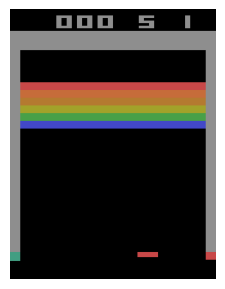

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.imshow(state)
ax.axis('off');

## Entrenamiento con `stable_baselines3`

Para facilitar el entrenamiento se recomienda hacer un preprocesamiento como el que sigue:

1. Reescalar la imagen a un menor tamaño
1. Combinar los canales y generar una imagen de escala de grises
1. Crear un stack de cuatro frames como representación del estado
1. Convertir los pixeles a float y normalizar al rango [0, 1]

Adicionalmente es muy útil entrenar con más de un ambiente al mismo tiempo en paralelo. 

Para esto usaremos los wrappers vectoriales de `stable_baselines3`:

Tamaño del tensor transformado: ((4, 84, 84, 4), dtype('uint8'))


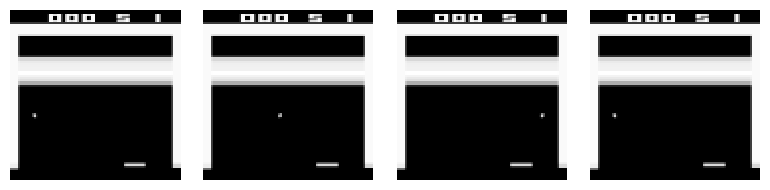

In [4]:
import numpy as np
import torch
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

env = VecFrameStack(make_atari_env(env_name, n_envs=4), n_stack=4)

env.reset()
state, _, _, _ = env.step([2, 2, 2, 2])

print(f"Tamaño del tensor transformado: {state.shape, state.dtype}")
fig, ax = plt.subplots(1, 4, figsize=(8, 2), tight_layout=True)
for k in range(4):
    ax[k].matshow(state[k, :, :, 2], cmap=plt.cm.Greys_r);
    ax[k].axis('off')

Veamos un agente aleatorio desempeñándose en este ambiente:

/home/phuijse/.conda/envs/RL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


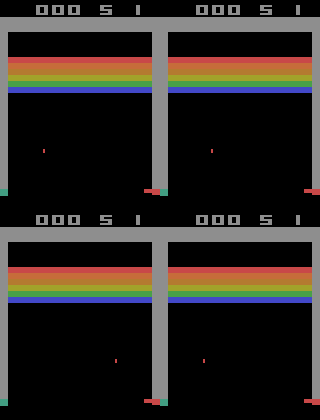

In [5]:
import imageio
import IPython

images = []

obs = env.reset()
for k in range(100):
    action = env.action_space.sample()
    obs, rewards, end, info = env.step([action]*4)
    img = env.render("rgb_array")
    images.append(img)

!rm random.gif
imageio.mimsave("random.gif", [np.array(img) for img in images], format='GIF', duration=1)
IPython.display.Image("random.gif")

Para entrenar el agente utilizaremos una red convolucional `CnnPolicy`. Utilizaremos un buffer de tamaño 100.000 y  durante las primeros 100.000 pasos no entrenamos, sólo llenamos el buffer. 

:::{warning}

Para llegar a un buen resultado en los ambientes de Atari con DQN se necesitan al menos 1.000.000 de pasos con la configuración que se muestra a continuación. Se recomienda utilizar una GPU para entrenar. En la práctica también es recomendable utilizar algoritmos más eficientes como A3C.

:::

In [8]:
%%time

import torch
from stable_baselines3 import DQN

np.random.seed(1234)
torch.manual_seed(1234)

env.reset()
model = DQN("CnnPolicy", env, verbose=1, tensorboard_log="/tmp/tensorboard/dqn_atari/",
            gamma=0.99, learning_rate=1e-4, batch_size=32, buffer_size=100_000, 
            target_update_interval=1_000, train_freq=4, gradient_steps=1,
            learning_starts=100_000, 
            exploration_fraction=0.1, exploration_final_eps=0.01, 
            )

model.learn(total_timesteps=10_000_000)

KeyboardInterrupt: 

CPU times: user 8.3 s, sys: 135 ms, total: 8.44 s
Wall time: 7.68 s


Las métricas del entrenamiento en este caso:

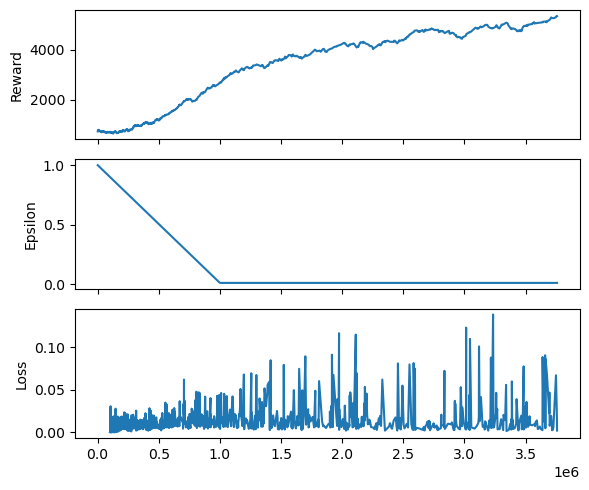

In [19]:
import pandas as pd

reward = pd.read_csv("metrics/rewards.csv")[['Step', 'Value']].values
epsilon = pd.read_csv("metrics/epsilon.csv")[['Step', 'Value']].values
loss = pd.read_csv("metrics/loss.csv")[['Step', 'Value']].values

fig, ax = plt.subplots(3, 1, figsize=(6, 5), tight_layout=True, sharex=True)
ax[0].plot(rewards[:, 0], rewards[:, 1])
ax[0].set_ylabel('Reward')
ax[1].plot(epsilon[:, 0], epsilon[:, 1])
ax[1].set_ylabel('Epsilon')
ax[2].plot(loss[:, 0], loss[:, 1])
ax[2].set_ylabel('Loss');
ax[2].set_xlabel('Epoca');

El mejor modelo se puede guardar en respaldar en disco con: 

In [22]:
model.save("dqn_breakout")

El modelo guardado se puede cargar desde disco para evaluarse o también seguir entrenándose volviendo a ejecutar `learn`

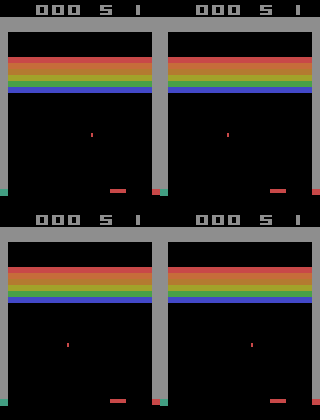

In [6]:
import numpy as np
import imageio
import IPython
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import DQN

env = VecFrameStack(make_atari_env(env_name, n_envs=4), n_stack=4)

loaded_model = DQN.load("dqn_breakout")

images = []

obs = env.reset()
for k in range(100):
    action, _state = loaded_model.predict(obs)
    obs, rewards, end, info = env.step(action)
    img = env.render("rgb_array")
    images.append(img)

!rm trained.gif
imageio.mimsave("trained.gif", [np.array(img) for img in images], format='GIF', duration=1)
IPython.display.Image("trained.gif")